In [27]:
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.filters import gaussian
import json
import argparse
import os
import zarr
import mrcfile
import re

def width_to_sigma(width, eps, lower_bound, upper_bound):
    # shrink needs to be between 0 and 1
    sigma = np.sqrt(-(width**2) / (2*np.log(eps)))
    #### bounding ####
    if lower_bound and upper_bound:
        if sigma < lower_bound:
            sigma = lower_bound
        elif sigma > upper_bound:
            sigma = upper_bound

    return int(sigma)

def create_gaussian_stamp(width, eps, lower_bound, upper_bound):
    """
    Creates a 3D Gaussian stamp (cube) with size width x width x width.
    If width is even, set width = width - 1.
    """
    if width % 2 == 0:
        width = width - 1
    
    sigma = width_to_sigma(width, eps, lower_bound, upper_bound)
    
    # Create a 3D matrix (stamp)
    stamp = np.zeros((width, width, width))
    center = width // 2
    
    # Set the center point to 1 (Gaussian peak)
    stamp[center, center, center] = 1

    # Apply 3D Gaussian filter to create the Gaussian distribution in 3D space
    #stamp = gaussian_filter(stamp, sigma=sigma)
    #Julia:
    stamp = gaussian(stamp, sigma=sigma, truncate=10.0, mode='constant')
    
    # Threshold the values based on epsilon and apply the scaling factor
    stamp[stamp < eps] = 0
    factor_3d = 2.5 #I had 1.6 as values for the centres of the gaussians before, but it should be 4, so 4/1.6=2.5
    stamp = stamp * 8 * factor_3d * np.pi * sigma**3

    return stamp
    
def parse_json_files(json_files):
    """
    Parse multiple JSON files to extract coordinates and protein names.

    Parameters:
        json_files (list of str): List of JSON file paths.

    Returns:
        list of tuples, list: Extracted coordinates and corresponding protein types.
    """
    coordinates = []
    protein_types = []

    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)

            points = data.get("points", [])
            for point in points:
                location = point.get("location", {})
                x = location.get("x")
                y = location.get("y")
                z = location.get("z")
                if x is not None and y is not None and z is not None:
                    coordinates.append((z / 10, y / 10, x / 10))  # Scale coordinates as needed
                    protein_types.append(data.get("pickable_object_name", "unknown"))

    return coordinates, protein_types

def create_width_dict_mrc(only_new_proteins=True):
    """
    Create a dictionary mapping protein names to widths.

    Returns:
        dict: Protein name to width mapping.
    """
    # Define protein lists
    PROTEINS_LIST = [
        "in_10A/4v4r_10A.pns",
        "in_10A/3j9i_10A.pns",
        "in_10A/4v4r_50S_10A.pns",
        "in_10A/4v4r_30S_10A.pns",
        "in_10A/6utj_10A.pns",
        "in_10A/5mrc_10A.pns",
        "in_10A/4v7r_10A.pns",
        "in_10A/2uv8_10A.pns",
        "in_10A/4v94_10A.pns",
        "in_10A/4cr2_10A.pns",
        "in_10A/3qm1_10A.pns",
        "in_10A/3h84_10A.pns",
        "in_10A/3gl1_10A.pns",
        "in_10A/3d2f_10A.pns",
        "in_10A/3cf3_10A.pns",
        "in_10A/2cg9_10A.pns",
        "in_10A/1u6g_10A.pns",
        "in_10A/1s3x_10A.pns",
        "in_10A/1qvr_10A.pns",
        "in_10A/1bxn_10A.pns",
    ]

    MB_PROTEINS_LIST = [
        "in_10A/mb_6rd4_10A.pms",
        "in_10A/mb_5wek_10A.pms",
        "in_10A/mb_4pe5_10A.pms",
        "in_10A/mb_5ide_10A.pms",
        "in_10A/mb_5gjv_10A.pms",
        "in_10A/mb_5kxi_10A.pms",
        "in_10A/mb_5tj6_10A.pms",
        "in_10A/mb_5tqq_10A.pms",
        "in_10A/mb_5vai_10A.pms",
    ]

    # New proteins list
    # These are the new proteins that are not in the original list
    # and are not MB proteins
    NEW_PROTEINS_LIST = [
        "in_10A/1fa2_10A.pns",
        "in_10A/6drv_10A.pns",
        "in_10A/6n4v_10A.pns",
        "in_10A/6qzp_10A.pns",
        "in_10A/7n4y_10A.pns",
        "in_10A/8cpv_10A.pns",
        "in_10A/8vaf_10A.pns"]
    
    if only_new_proteins:
        ALL_PROTEINS = NEW_PROTEINS_LIST
    else:
        ALL_PROTEINS = MB_PROTEINS_LIST + NEW_PROTEINS_LIST + PROTEINS_LIST
    
    
    def extract_mrc_path(protein_file):
        """Extracts MMER_SVOL path from a .pns or .pms file."""
        try:
            with open(protein_file, "r") as f:
                for line in f:
                    match = re.search(r"MMER_SVOL\s*=\s*(\S+)", line)
                    if match:
                        return match.group(1)  # Return the MRC file path
        except FileNotFoundError:
            print(f"File not found: {protein_file}")
        return None

    def get_mrc_dimensions(mrc_path):
        """Extracts the dimensions of a protein from an MRC file."""
        try:
            with mrcfile.open(mrc_path, permissive=True) as mrc:
                # Log voxel size and data shape for debugging
                print(f"Processing MRC file: {mrc_path}")
                print(f"Voxel size: x={mrc.voxel_size.x}, y={mrc.voxel_size.y}, z={mrc.voxel_size.z}")
                print(f"Data shape: {mrc.data.shape}")

                # Ensure voxel size is correctly interpreted
                voxel_size_x = mrc.voxel_size.x if mrc.voxel_size.x > 0 else 1
                voxel_size_y = mrc.voxel_size.y if mrc.voxel_size.y > 0 else 1
                voxel_size_z = mrc.voxel_size.z if mrc.voxel_size.z > 0 else 1

                # Get the data shape (z, y, x)
                data_shape = mrc.data.shape

                # Calculate dimensions in nanometers
                dimensions = [
                    data_shape[2] * voxel_size_x,  # X dimension
                    data_shape[1] * voxel_size_y,  # Y dimension
                    data_shape[0] * voxel_size_z   # Z dimension
                ]

                print(f"Calculated dimensions (nm): {dimensions}")
                return max(dimensions) / 10  # Convert to desired unit (e.g., nanometers to angstroms)
        except Exception as e:
            print(f"Error processing {mrc_path}: {e}")
            return None
    
    # Dictionary to store protein names and their widths
    protein_widths = {}
    root_dir_new_proteins = "/Users/yusufberkoruc/Desktop/Master_thesis/polnet/data"
    root_dir_proteins = "/Users/yusufberkoruc/Desktop/Master_thesis/new_polnet/polnet/data/"

    for protein_file in ALL_PROTEINS:
        # Construct the full path to the protein file
        if protein_file in PROTEINS_LIST or protein_file in MB_PROTEINS_LIST:
            root_dir = root_dir_proteins
        else:
            root_dir = root_dir_new_proteins
        protein_file_full_path = os.path.join(root_dir, protein_file)
        
        # Extract the MRC file path
        mrc_path = extract_mrc_path(protein_file_full_path)
        
        if mrc_path:
            # Construct the full path to the MRC file
            mrc_path_full = os.path.join(root_dir, mrc_path.lstrip("/"))
            
            if os.path.exists(mrc_path_full):
                # Calculate the width (largest dimension)
                width = get_mrc_dimensions(mrc_path_full)
                
                if width:
                    # Extract the protein name (e.g., mb_5gjv_10A)
                    protein_name = os.path.basename(protein_file).replace(".pns", "").replace(".pms", "")
                    
                    # Add to the dictionary
                    protein_widths[protein_name] = width
                else:
                    print(f"Could not determine width for {protein_file}")
            else:
                print(f"MRC file not found: {mrc_path_full}")
        else:
            print(f"No MMER_SVOL found in {protein_file}")
    return protein_widths

def create_width_dict_pdb():
    """
    Create a dictionary mapping protein names to widths.

    Returns:
        dict: Protein name to width mapping.
    """
    return {
        "8cpv_10A": 79.07,
        "1fa2_10A": 33.27,
        "6drv_10A": 57.44,
        "6qzp_10A": 109.02,
        "7n4y_10A": 76.47,
        "6n4v_10A": 79.07,
        "8vaf_10A": 48.00
    }

def create_width_dict():
    """
    Create a dictionary mapping protein names to widths.

    Returns:
        dict: Protein name to width mapping.
    """
    return {
        "apo-ferritin": 79.07,
        "beta-amylase": 33.27,
        "beta-galactosidase": 57.44,
        "ribosome": 109.02,
        "thyroglobulin": 76.47,
        "virus-like-particle": 120.00,
        "albumin": 48.00,
    }
def precompute_gaussians(width_dict, eps, lower_bound, upper_bound):
    return {protein: create_gaussian_stamp(int(width * 0.3), eps, lower_bound, upper_bound) for protein, width in width_dict.items()}

def create_heatmap(json_folder, image_shape, eps=0.00001, sigma=None, lower_bound=None, upper_bound=None, bb=None):
    """
    Process a tomogram by creating a heatmap based on protein data from JSON files,
    with optional bounding box constraints.

    Parameters:
        json_folder (str): Path to the folder containing JSON files.
        image_shape (tuple): Shape of the 3D image (z, y, x).
        eps (float): Threshold for truncating the Gaussian.
        sigma (float, optional): Fixed sigma value for Gaussian.
        lower_bound (float, optional): Minimum allowed sigma.
        upper_bound (float, optional): Maximum allowed sigma.
        bb (tuple, optional): Bounding box (z_min, z_max, y_min, y_max, x_min, x_max).

    Returns:
        np.ndarray: Generated 3D heatmap.
    """
    picks_folder = os.path.join(json_folder, "Picks")
    json_files = [os.path.join(picks_folder, f) for f in os.listdir(picks_folder) if f.endswith('.json')]
    coordinates, protein_types = parse_json_files(json_files)
    width_dict = create_width_dict()
    gaussian_dict = precompute_gaussians(width_dict, eps, lower_bound, upper_bound)
    
    if bb:
        (z_min, z_max), (y_min, y_max), (x_min, x_max) = [(s.start, s.stop) for s in bb]
        restricted_shape = (z_max - z_min, y_max - y_min, x_max - x_min)
        heatmap = np.zeros(restricted_shape)
    else:
        heatmap = np.zeros(image_shape)
    
    for coord, protein in zip(coordinates, protein_types):
        z, y, x = map(int, coord)
        gaussian = gaussian_dict.get(protein, create_gaussian_stamp(1, eps, lower_bound, upper_bound))
        
        if bb and not (z_min <= z < z_max and y_min <= y < y_max and x_min <= x < x_max):
            continue
        
        z_offset, y_offset, x_offset = (z_min, y_min, x_min) if bb else (0, 0, 0)
        z, y, x = z - z_offset, y - y_offset, x - x_offset
        
        z_min_hm = max(0, z - gaussian.shape[0] // 2)
        z_max_hm = min(heatmap.shape[0], z + gaussian.shape[0] // 2 + 1)
        y_min_hm = max(0, y - gaussian.shape[1] // 2)
        y_max_hm = min(heatmap.shape[1], y + gaussian.shape[1] // 2 + 1)
        x_min_hm = max(0, x - gaussian.shape[2] // 2)
        x_max_hm = min(heatmap.shape[2], x + gaussian.shape[2] // 2 + 1)
        
        heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm] = np.maximum(
            heatmap[z_min_hm:z_max_hm, y_min_hm:y_max_hm, x_min_hm:x_max_hm],
            gaussian[
                (z_min_hm - (z - gaussian.shape[0] // 2)):(z_max_hm - (z - gaussian.shape[0] // 2)),
                (y_min_hm - (y - gaussian.shape[1] // 2)):(y_max_hm - (y - gaussian.shape[1] // 2)),
                (x_min_hm - (x - gaussian.shape[2] // 2)):(x_max_hm - (x - gaussian.shape[2] // 2))
            ]
        )
    
    return heatmap

def get_label(json_folder, image_shape, eps=0.00001, sigma=None, lower_bound=None, upper_bound=None, bb=None):

    have_single_file = isinstance(json_folder, str)

    if have_single_file:
        return create_heatmap(json_folder, image_shape, eps, sigma, lower_bound, upper_bound, bb)
    else:
        print(f"len json folder {len(json_folder)}")
        return np.stack([create_heatmap(p, image_shape, eps, sigma, lower_bound, upper_bound, bb) for p in json_folder])

def get_tomo_shape(file_path):
    """
    Get the shape of a tomogram stored in either a Zarr or MRC file.
    
    Parameters:
        file_path (str): Path to the file (either .zarr or .mrc).
    
    Returns:
        tuple: Shape of the tomogram, or None if not found.
    """
    if file_path.endswith(".zarr"):
        zarr_store = zarr.open(file_path, mode='r')
        return zarr_store["0"].shape if "0" in zarr_store else None

    elif file_path.endswith(".mrc"):
        with mrcfile.open(file_path, mode="r") as mrc:
            return mrc.data.shape  # MRC files store data as (Z, Y, X)

    return None  # Unsupported file format



In [28]:
def main(file_path=None, json_folder=None, output_folder=None):
    
    tomogram_shape = get_tomo_shape(file_path)
    if tomogram_shape is not None:
        os.makedirs(output_folder, exist_ok=True)
        tomogram_index = 0
        output_file =  os.path.join(output_folder, f"{tomogram_index}_heatmap.npy")

        heatmap =get_label(json_folder, tomogram_shape)

        # Save the heatmap to a file
        np.save(output_file, heatmap)
        print(f"Heatmap saved to {output_file}")

    else:
        print("No 0 zarr was found")
        print("No tomogram shape found. Please check the file path or format.")


In [29]:
"""file_path = "/Users/yusufberkoruc/Desktop/Master_thesis/train_directory/static/ExperimentRuns_faket/tomogram_0_0/tomo_rec_faket_0.mrc"
json_folder = "/Users/yusufberkoruc/Desktop/Master_thesis/train_main/overlay/ExperimentRuns/tomogram_0_0"
output_folder = "/Users/yusufberkoruc/Desktop/Master_thesis/heat_map_output"
   
if __name__ == "__main__":
    main(file_path=file_path, json_folder=json_folder, output_folder=output_folder)"""

'file_path = "/Users/yusufberkoruc/Desktop/Master_thesis/train_directory/static/ExperimentRuns_faket/tomogram_0_0/tomo_rec_faket_0.mrc"\njson_folder = "/Users/yusufberkoruc/Desktop/Master_thesis/train_main/overlay/ExperimentRuns/tomogram_0_0"\noutput_folder = "/Users/yusufberkoruc/Desktop/Master_thesis/heat_map_output"\n   \nif __name__ == "__main__":\n    main(file_path=file_path, json_folder=json_folder, output_folder=output_folder)'

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mrcfile
import zarr
import napari
import json
from glob import glob

def extract_points_from_json(json_file, voxel_size):
    """
    Extract points from a JSON file and scale them to match the tomogram's frame.

    Parameters:
        json_file (str): Path to the JSON file.
        voxel_size (tuple): Voxel size in the tomogram (z, y, x) in the same units as the JSON coordinates.

    Returns:
        np.ndarray: Scaled points as a NumPy array.
    """
    with open(json_file, 'r') as f:
        data = json.load(f)
    if "points" not in data:
        return None
    points = []
    for pt in data["points"]:
        loc = pt["location"]
        # Convert [X, Y, Z] → [Z, Y, X] for Napari and scale by voxel size
        points.append([
            loc["z"] / voxel_size[0],
            loc["y"] / voxel_size[1],
            loc["x"] / voxel_size[2]
        ])
    return np.array(points)

def visualize_heatmap_with_gt(
        simulation_dir, heat_map_path, train_dir, tomogram_id,
        json_dir_path=None, tomogram_prefix="tomogram_",
        ground_truth_add=False, density_add=False, show_3d=False):
    
    tomogram_id = str(tomogram_id)
    tomogram_folder_name = f"{tomogram_prefix}{tomogram_id}"

    # --- Load Heatmap ---
    heatmap = np.load(heat_map_path)
    print(f"✅ Loaded heatmap from {heat_map_path}")
    heatmap = heatmap  # Assume 4D: (C, Z, Y, X)

    # --- Load Tomogram (.zarr or .mrc) ---
    mrc_dir = os.path.join(train_dir, "ExperimentRuns_faket", tomogram_folder_name)
    if not os.path.exists(mrc_dir):
        raise FileNotFoundError(f"Tomogram folder not found: {mrc_dir}")

    tomogram = None
    for root, dirs, files in os.walk(mrc_dir):
        for d in dirs:
            if d.endswith(".zarr"):
                zarr_path = os.path.join(root, d, "0")
                try:
                    tomogram = zarr.open(zarr_path, mode="r")[:]
                    print(f"✅ Loaded tomogram from Zarr: {zarr_path}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed loading Zarr: {e}")
        if tomogram is not None:
            break
        for f in files:
            if f.endswith(".mrc") and "tomo_rec_" in f:
                mrc_path = os.path.join(root, f)
                with mrcfile.open(mrc_path, permissive=True) as mrc:
                    tomogram = mrc.data
                print(f"✅ Loaded tomogram from MRC: {mrc_path}")
                break
        if tomogram is not None:
            break
    if tomogram is None:
        raise FileNotFoundError("❌ Tomogram not found")

    # --- Ground Truth ---
    tomogram_id_gt = tomogram_id.split("_")[-1]
    ground_truth = None
    for root, _, files in os.walk(simulation_dir):
        for f in files:
            if f == f"tomo_lbls_{tomogram_id_gt}.mrc":
                with mrcfile.open(os.path.join(root, f), permissive=True) as gt:
                    ground_truth = gt.data
                print(f"✅ Loaded ground truth: {f}")
                break

    # --- Density ---
    density = None
    density_file = os.path.join(simulation_dir, f"tomo_den_{tomogram_id_gt}.mrc")
    if os.path.exists(density_file):
        with mrcfile.open(density_file, permissive=True) as den:
            density = den.data
        print(f"✅ Loaded density: {density_file}")

    # --- Multiple JSON Points ---
    json_points_dict = {}
    voxel_size = (10.0, 10.0, 10.0)  # Example voxel size in Ångstroms
    if json_dir_path and os.path.isdir(json_dir_path):
        json_files = glob(os.path.join(json_dir_path, "*.json"))
        for jf in json_files:
            label = os.path.splitext(os.path.basename(jf))[0]
            points = extract_points_from_json(jf, voxel_size)
            if points is not None and len(points) > 0:
                json_points_dict[label] = points
        print(f"✅ Loaded {len(json_points_dict)} JSON files with points")
    else:
        print(f"⚠️ No valid JSON directory: {json_dir_path}")

    # --- Sanity Check ---
    if heatmap.shape != tomogram.shape:
        print(f"⚠️ Shape mismatch:\n  Heatmap: {heatmap.shape}\n  Tomogram: {tomogram.shape}")

    # --- Peak Info ---
    peak_value = np.max(heatmap)
    peak_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    z, y, x = peak_coords
    print(f"🔥 Peak value: {peak_value:.4f} at Z: {z}, Y: {y}, X: {x}")

    # --- Preview ---
    plt.imshow(heatmap[z], cmap='hot')
    plt.colorbar()
    plt.title(f"Heatmap Z={z} | Peak={peak_value:.2f}")
    plt.show()

    # --- Napari Viewer ---
    viewer = napari.Viewer(ndisplay=3 if show_3d else 2)
    viewer.add_image(tomogram, name="Tomogram", colormap="gray", blending="additive")
    viewer.add_image(heatmap, name="Heatmap", colormap="red", opacity=0.5, blending="additive")
    if ground_truth is not None and ground_truth_add:
        viewer.add_image(ground_truth, name="Ground Truth", colormap="gray", opacity=0.5)
    if density is not None and density_add:
        viewer.add_image(density, name="Density", colormap="blue", opacity=0.5)

    # Add each set of JSON points as its own layer
    for label, pts in json_points_dict.items():
        viewer.add_points(pts, size=10, face_color='yellow', name=label, out_of_slice_display=True, ndim=3)

    napari.run()


In [31]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def visualize_heatmap_with_gt(
        simulation_dir, heat_map_path, train_dir, tomogram_id,
        json_dir_path=None, tomogram_prefix="tomogram_",
        ground_truth_add=False, density_add=False, show_3d=False):
    
    tomogram_id = str(tomogram_id)
    tomogram_folder_name = f"{tomogram_prefix}{tomogram_id}"

    # --- Load Heatmap ---
    heatmap = np.load(heat_map_path)
    print(f"✅ Loaded heatmap from {heat_map_path}")
    heatmap = heatmap  # Assume 4D: (C, Z, Y, X)

    # --- Load Tomogram (.zarr or .mrc) ---
    mrc_dir = os.path.join(train_dir, "ExperimentRuns_faket", tomogram_folder_name)
    if not os.path.exists(mrc_dir):
        raise FileNotFoundError(f"Tomogram folder not found: {mrc_dir}")

    tomogram = None
    for root, dirs, files in os.walk(mrc_dir):
        for d in dirs:
            if d.endswith(".zarr"):
                zarr_path = os.path.join(root, d, "0")
                try:
                    tomogram = zarr.open(zarr_path, mode="r")[:]
                    print(f"✅ Loaded tomogram from Zarr: {zarr_path}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed loading Zarr: {e}")
        if tomogram is not None:
            break
        for f in files:
            if f.endswith(".mrc") and "tomo_rec_" in f:
                mrc_path = os.path.join(root, f)
                with mrcfile.open(mrc_path, permissive=True) as mrc:
                    tomogram = mrc.data
                print(f"✅ Loaded tomogram from MRC: {mrc_path}")
                break
        if tomogram is not None:
            break
    if tomogram is None:
        raise FileNotFoundError("❌ Tomogram not found")

    # --- Ground Truth ---
    tomogram_id_gt = tomogram_id.split("_")[-1]
    ground_truth = None
    for root, _, files in os.walk(simulation_dir):
        for f in files:
            if f == f"tomo_lbls_{tomogram_id_gt}.mrc":
                with mrcfile.open(os.path.join(root, f), permissive=True) as gt:
                    ground_truth = gt.data
                print(f"✅ Loaded ground truth: {f}")
                break

    # --- Density ---
    density = None
    density_file = os.path.join(simulation_dir, f"tomo_den_{tomogram_id_gt}.mrc")
    if os.path.exists(density_file):
        with mrcfile.open(density_file, permissive=True) as den:
            density = den.data
        print(f"✅ Loaded density: {density_file}")

    # --- Multiple JSON Points ---
    json_points_dict = {}
    voxel_size = (10.0, 10.0, 10.0)  # Example voxel size in Ångstroms
    if json_dir_path and os.path.isdir(json_dir_path):
        json_files = glob(os.path.join(json_dir_path, "*.json"))
        for jf in json_files:
            label = os.path.splitext(os.path.basename(jf))[0]
            points = extract_points_from_json(jf, voxel_size)
            if points is not None and len(points) > 0:
                json_points_dict[label] = points
        print(f"✅ Loaded {len(json_points_dict)} JSON files with points")
    else:
        print(f"⚠️ No valid JSON directory: {json_dir_path}")

    # --- Sanity Check ---
    if heatmap.shape != tomogram.shape:
        print(f"⚠️ Shape mismatch:\n  Heatmap: {heatmap.shape}\n  Tomogram: {tomogram.shape}")

    # --- Peak Info ---
    peak_value = np.max(heatmap)
    peak_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    z, y, x = peak_coords
    print(f"🔥 Peak value: {peak_value:.4f} at Z: {z}, Y: {y}, X: {x}")

    # --- Preview ---
    plt.imshow(heatmap[z], cmap='hot')
    plt.colorbar()
    plt.title(f"Heatmap Z={z} | Peak={peak_value:.2f}")
    plt.show()

    # --- Napari Viewer ---
    viewer = napari.Viewer(ndisplay=3 if show_3d else 2)
    viewer.add_image(tomogram, name="Tomogram", colormap="gray", blending="additive")
    viewer.add_image(heatmap, name="Heatmap", colormap="red", opacity=0.5, blending="additive")
    if ground_truth is not None and ground_truth_add:
        viewer.add_image(ground_truth, name="Ground Truth", colormap="gray", opacity=0.5)
    if density is not None and density_add:
        viewer.add_image(density, name="Density", colormap="blue", opacity=0.5)

    # Add each set of JSON points as its own layer with unique colors
    cmap = get_cmap("tab20")  # Use a colormap with distinct colors
    norm = Normalize(vmin=0, vmax=len(json_points_dict) - 1)
    for idx, (label, pts) in enumerate(json_points_dict.items()):
        color = np.array(cmap(norm(idx)))  # Convert RGBA tuple to NumPy array
        viewer.add_points(
            pts,
            size=10,
            face_color=[color] * len(pts),  # Repeat the color for all points
            name=label,
            out_of_slice_display=True,
            ndim=3
        )

    napari.run()

In [32]:
"""visualize_heatmap_with_gt(
    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",
    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/heat_map_output/0_heatmap.npy",
    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/train_directory/static",
    tomogram_id="0_0",
    json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/train_main/overlay/ExperimentRuns/tomogram_0_0/Picks",  # e.g., with all *.json files inside
    ground_truth_add=True,
    density_add=True,
    show_3d=True
)
"""

'visualize_heatmap_with_gt(\n    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",\n    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/heat_map_output/0_heatmap.npy",\n    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/train_directory/static",\n    tomogram_id="0_0",\n    json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/train_main/overlay/ExperimentRuns/tomogram_0_0/Picks",  # e.g., with all *.json files inside\n    ground_truth_add=True,\n    density_add=True,\n    show_3d=True\n)\n'

In [33]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def visualize_heatmap_with_predictions_and_gt(
        simulation_dir, heat_map_path, train_dir, tomogram_id,
        gt_json_dir_path=None, prediction_json_path=None, tomogram_prefix="TS_",
        ground_truth_add=False, density_add=False, show_3d=False):
    
    tomogram_id = str(tomogram_id)
    tomogram_folder_name = f"{tomogram_prefix}{tomogram_id}"

    # --- Load Heatmap ---
    heatmap = np.load(heat_map_path)
    print(f"✅ Loaded heatmap from {heat_map_path}")
    heatmap = heatmap  # Assume 4D: (C, Z, Y, X)

    # --- Load Tomogram (.zarr or .mrc) ---
    mrc_dir = os.path.join(train_dir, "ExperimentRuns", tomogram_folder_name)
    if not os.path.exists(mrc_dir):
        raise FileNotFoundError(f"Tomogram folder not found: {mrc_dir}")

    tomogram = None
    for root, dirs, files in os.walk(mrc_dir):
        for d in dirs:
            if d.endswith(".zarr"):
                zarr_path = os.path.join(root, d)
                try:
                    tomogram = zarr.open(zarr_path, mode="r")["0"][:]  # Read Zarr file with key "0"
                    print(f"✅ Loaded tomogram from Zarr: {zarr_path}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed loading Zarr: {e}")
        if tomogram is not None:
            break
        for f in files:
            if f.endswith(".mrc") and "tomo_rec_" in f:
                mrc_path = os.path.join(root, f)
                with mrcfile.open(mrc_path, permissive=True) as mrc:
                    tomogram = mrc.data
                print(f"✅ Loaded tomogram from MRC: {mrc_path}")
                break
        if tomogram is not None:
            break
    if tomogram is None:
        raise FileNotFoundError("❌ Tomogram not found")

    # --- Ground Truth ---
    gt_points_dict = {}
    voxel_size = (10.0, 10.0, 10.0)  # Example voxel size in Ångstroms
    if gt_json_dir_path and os.path.isdir(gt_json_dir_path):
        gt_json_files = glob(os.path.join(gt_json_dir_path, "*.json"))
        for jf in gt_json_files:
            label = os.path.splitext(os.path.basename(jf))[0]
            points = extract_points_from_json(jf, voxel_size)
            if points is not None and len(points) > 0:
                gt_points_dict[label] = points
        print(f"✅ Loaded {len(gt_points_dict)} ground truth JSON files")
    else:
        print(f"⚠️ No valid ground truth JSON directory: {gt_json_dir_path}")

    # --- Predictions from JSON ---
    prediction_points = None
    if prediction_json_path and os.path.exists(prediction_json_path):
        with open(prediction_json_path, 'r') as f:
            prediction_data = json.load(f)
        if "points" in prediction_data:
            prediction_points = []
            for pt in prediction_data["points"]:
                loc = pt["location"]
                # Convert [X, Y, Z] → [Z, Y, X] for Napari and scale by voxel size
                prediction_points.append([
                    loc["z"] / voxel_size[0],
                    loc["y"] / voxel_size[1],
                    loc["x"] / voxel_size[2]
                ])
            prediction_points = np.array(prediction_points)
        print(f"✅ Loaded predictions from {prediction_json_path}")

    # --- Sanity Check ---
    if heatmap.shape != tomogram.shape:
        print(f"⚠️ Shape mismatch:\n  Heatmap: {heatmap.shape}\n  Tomogram: {tomogram.shape}")

    # --- Peak Info ---
    peak_value = np.max(heatmap)
    peak_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    z, y, x = peak_coords
    print(f"🔥 Peak value: {peak_value:.4f} at Z: {z}, Y: {y}, X: {x}")

    # --- Preview ---
    plt.imshow(heatmap[z], cmap='hot')
    plt.colorbar()
    plt.title(f"Heatmap Z={z} | Peak={peak_value:.2f}")
    plt.show()

    # --- Napari Viewer ---
    viewer = napari.Viewer(ndisplay=3 if show_3d else 2)
    viewer.add_image(tomogram, name="Tomogram", colormap="gray", blending="additive")
    viewer.add_image(heatmap, name="Heatmap", colormap="red", opacity=0.5, blending="additive")
    if ground_truth is not None and ground_truth_add:
        viewer.add_image(ground_truth, name="Ground Truth", colormap="gray", opacity=0.5)
    if density is not None and density_add:
        viewer.add_image(density, name="Density", colormap="blue", opacity=0.5)

    # Add ground truth points as separate layers with unique colors
    cmap = get_cmap("tab20")  # Use a colormap with distinct colors
    norm = Normalize(vmin=0, vmax=len(gt_points_dict) - 1)
    for idx, (label, pts) in enumerate(gt_points_dict.items()):
        color = np.array(cmap(norm(idx)))  # Convert RGBA tuple to NumPy array
        viewer.add_points(
            pts,
            size=10,
            face_color=[color] * len(pts),  # Repeat the color for all points
            name=f"GT: {label}",
            out_of_slice_display=True,
            ndim=3
        )

    # Add predictions as a separate layer
    if prediction_points is not None:
        viewer.add_points(
            prediction_points,
            size=10,
            face_color="cyan",  # Use a distinct color for predictions
            name="Predictions",
            out_of_slice_display=True,
            ndim=3
        )

    napari.run()

In [34]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def visualize_heatmap_with_predictions_and_gt(
        simulation_dir, heat_map_path, train_dir, tomogram_id,
        gt_json_dir_path=None, prediction_json_path=None, tomogram_prefix="tomogram_",
        ground_truth_add=False, density_add=False, show_3d=False):
    
    tomogram_id = str(tomogram_id)
    tomogram_folder_name = f"{tomogram_prefix}{tomogram_id}"

    # --- Load Heatmap ---
    heatmap = np.load(heat_map_path)
    if heatmap.ndim == 4:
        heatmap = heatmap[0]
    print(f"✅ Loaded heatmap from {heat_map_path}")
    heatmap = heatmap  # Assume 4D: (C, Z, Y, X)

    # --- Load Tomogram (Denoised Zarr Only) ---
    mrc_dir = os.path.join(train_dir, "ExperimentRuns", tomogram_folder_name)
    if not os.path.exists(mrc_dir):
        raise FileNotFoundError(f"Tomogram folder not found: {mrc_dir}")

    tomogram = None
    for root, dirs, files in os.walk(mrc_dir):
        for d in dirs:
            if d.endswith(".zarr") and "denoised" in d:  # Ensure only denoised Zarr is loaded
                zarr_path = os.path.join(root, d)
                try:
                    tomogram = zarr.open(zarr_path, mode="r")["0"][:]  # Read Zarr file with key "0"
                    print(f"✅ Loaded denoised tomogram from Zarr: {zarr_path}")
                    break
                except Exception as e:
                    print(f"⚠️ Failed loading Zarr: {e}")
        if tomogram is not None:
            break
        for f in files:
            if f.endswith(".mrc") and "tomo_rec_" in f:
                mrc_path = os.path.join(root, f)
                with mrcfile.open(mrc_path, permissive=True) as mrc:
                    tomogram = mrc.data
                print(f"✅ Loaded tomogram from MRC: {mrc_path}")
                break
        if tomogram is not None:
            break
    if tomogram is None:
        raise FileNotFoundError("❌ Denoised tomogram not found")

    # --- Ground Truth ---
    gt_points_dict = {}
    voxel_size = (10.0, 10.0, 10.0)  # Example voxel size in Ångstroms
    if gt_json_dir_path and os.path.isdir(gt_json_dir_path):
        gt_json_files = glob(os.path.join(gt_json_dir_path, "*.json"))
        for jf in gt_json_files:
            label = os.path.splitext(os.path.basename(jf))[0]
            points = extract_points_from_json(jf, voxel_size)
            if points is not None and len(points) > 0:
                gt_points_dict[label] = points
        print(f"✅ Loaded {len(gt_points_dict)} ground truth JSON files")
    else:
        print(f"⚠️ No valid ground truth JSON directory: {gt_json_dir_path}")

    # --- Predictions from JSON ---
    """prediction_points = None
    if prediction_json_path and os.path.exists(prediction_json_path):
        with open(prediction_json_path, 'r') as f:
            prediction_data = json.load(f)
        if "points" in prediction_data:
            prediction_points = []
            for pt in prediction_data["points"]:
                loc = pt["location"]
                # Convert [X, Y, Z] → [Z, Y, X] for Napari and scale by voxel size
                prediction_points.append([
                    loc["z"] / voxel_size[0],
                    loc["y"] / voxel_size[1],
                    loc["x"] / voxel_size[2]
                ])
            prediction_points = np.array(prediction_points)
        print(f"✅ Loaded predictions from {prediction_json_path}")
"""
    # --- Predictions from JSON ---
    prediction_points = None
    if prediction_json_path and os.path.exists(prediction_json_path):
        with open(prediction_json_path, 'r') as f:
            prediction_data = json.load(f)
        if isinstance(prediction_data, list):  # Handle list of lists structure
            prediction_points = np.array(prediction_data)  # Directly convert to NumPy array
        print(f"✅ Loaded predictions from {prediction_json_path}")

    # --- Sanity Check ---
    if heatmap.shape != tomogram.shape:
        print(f"⚠️ Shape mismatch:\n  Heatmap: {heatmap.shape}\n  Tomogram: {tomogram.shape}")

    # --- Peak Info ---
    peak_value = np.max(heatmap)
    peak_coords = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    z, y, x = peak_coords
    print(f"🔥 Peak value: {peak_value:.4f} at Z: {z}, Y: {y}, X: {x}")

    # --- Preview ---
    plt.imshow(heatmap[z], cmap='hot')
    plt.colorbar()
    plt.title(f"Heatmap Z={z} | Peak={peak_value:.2f}")
    plt.show()

    # --- Napari Viewer ---
    viewer = napari.Viewer(ndisplay=3 if show_3d else 2)
    viewer.add_image(tomogram, name="Tomogram", colormap="gray", blending="additive")
    viewer.add_image(heatmap, name="Heatmap", colormap="red", opacity=0.5, blending="additive")
    

    # Add ground truth points as separate layers with unique colors
    cmap = get_cmap("tab20")  # Use a colormap with distinct colors
    norm = Normalize(vmin=0, vmax=len(gt_points_dict) - 1)
    for idx, (label, pts) in enumerate(gt_points_dict.items()):
        color = np.array(cmap(norm(idx)))  # Convert RGBA tuple to NumPy array
        viewer.add_points(
            pts,
            size=5,
            face_color=[color] * len(pts),  # Repeat the color for all points
            name=f"GT: {label}",
            out_of_slice_display=True,
            ndim=3,
            text={
    'string': [f"({z:.1f}, {y:.1f}, {x:.1f})" for z, y, x in pts],
    'anchor': 'upper_left',
    'color': 'black',
    'size': 5,
}
        )

    # Add predictions as a separate layer
    if prediction_points is not None:
        viewer.add_points(
            prediction_points,
            size=15,
            face_color="cyan",  # Use a distinct color for predictions
            name="Predictions",
            out_of_slice_display=True,
            ndim=3,
            text={
    'string': [f"({z:.1f}, {y:.1f}, {x:.1f})" for z, y, x in prediction_points],
    'anchor': 'upper_left',
    'color': 'blue',
    'size': 5,
    }
        )

    napari.run()

In [35]:
"""visualize_heatmap_with_predictions_and_gt(
    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",
    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_4/TS_86_3_protein_detections_peak_local_max.npy",
    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",
    tomogram_id="86_3",
    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory
    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_4/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file
    ground_truth_add=False,
    density_add=False,
    show_3d=True,tomogram_prefix="TS_"
)"""

'visualize_heatmap_with_predictions_and_gt(\n    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",\n    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_4/TS_86_3_protein_detections_peak_local_max.npy",\n    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",\n    tomogram_id="86_3",\n    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory\n    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_4/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file\n    ground_truth_add=False,\n    density_add=False,\n    show_3d=True,tomogram_prefix="TS_"\n)'

In [36]:
"""visualize_heatmap_with_predictions_and_gt(
    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",
    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.npy",
    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",
    tomogram_id="86_3",
    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory
    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file
    ground_truth_add=False,
    density_add=False,
    show_3d=True,tomogram_prefix="TS_"
)"""

'visualize_heatmap_with_predictions_and_gt(\n    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",\n    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.npy",\n    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",\n    tomogram_id="86_3",\n    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory\n    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file\n    ground_truth_add=False,\n    density_add=False,\n    show_3d=True,tomogram_prefix="TS_"\n)'

In [37]:
"""visualize_heatmap_with_predictions_and_gt(
    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",
    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/tomogram_0_2_protein_detections_peak_local_max.npy",
    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/train_main/static",
    tomogram_id="0_2",
    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/train_main/overlay/ExperimentRuns/tomogram_0_2/Picks",  # Ground truth JSON directory
    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/tomogram_0_2_protein_detections_peak_local_max.json",  # Prediction JSON file
    ground_truth_add=False,
    density_add=False,
    show_3d=True,tomogram_prefix="tomogram_"
)"""

'visualize_heatmap_with_predictions_and_gt(\n    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",\n    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/tomogram_0_2_protein_detections_peak_local_max.npy",\n    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/train_main/static",\n    tomogram_id="0_2",\n    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/train_main/overlay/ExperimentRuns/tomogram_0_2/Picks",  # Ground truth JSON directory\n    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/tomogram_0_2_protein_detections_peak_local_max.json",  # Prediction JSON file\n    ground_truth_add=False,\n    density_add=False,\n    show_3d=True,tomogram_prefix="tomogram_"\n)'

✅ Loaded heatmap from /Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_6/TS_86_3_protein_detections_peak_local_max.npy
✅ Loaded denoised tomogram from Zarr: /Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static/ExperimentRuns/TS_86_3/VoxelSpacing10.000/denoised.zarr
✅ Loaded 6 ground truth JSON files
✅ Loaded predictions from /Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_6/TS_86_3_protein_detections_peak_local_max.json
🔥 Peak value: 5.0056 at Z: 39, Y: 269, X: 24


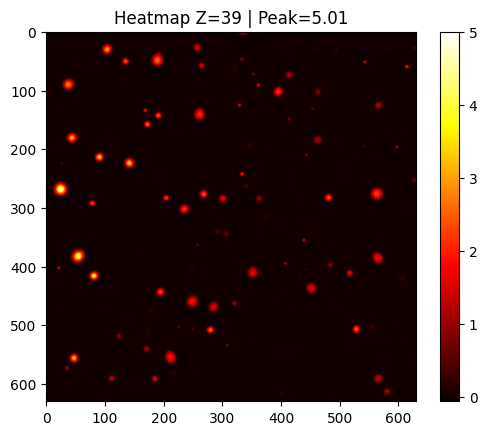

/var/folders/mv/121jwvcn4bn0ssxkmz3jh7vc0000gn/T/ipykernel_83432/286160953.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")  # Use a colormap with distinct colors


In [38]:
visualize_heatmap_with_predictions_and_gt(
    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",
    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_6/TS_86_3_protein_detections_peak_local_max.npy",
    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",
    tomogram_id="86_3",
    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory
    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/3d-adapted-model_6/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file
    ground_truth_add=False,
    density_add=False,
    show_3d=True,tomogram_prefix="TS_"
)

In [39]:
"""visualize_heatmap_with_predictions_and_gt(
    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",
    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.npy",
    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",
    tomogram_id="86_3",
    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory
    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file
    ground_truth_add=False,
    density_add=False,
    show_3d=True,tomogram_prefix="TS_"
)"""

'visualize_heatmap_with_predictions_and_gt(\n    simulation_dir="/Users/yusufberkoruc/Desktop/Master_thesis/simulation_dir_1/all_v_czii",\n    heat_map_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.npy",\n    train_dir="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/static",\n    tomogram_id="86_3",\n    gt_json_dir_path="/Users/yusufberkoruc/Desktop/Master_thesis/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_86_3/Picks",  # Ground truth JSON directory\n    prediction_json_path="/Users/yusufberkoruc/Desktop/Master_thesis/protein_detection_czii_main/TS_86_3_protein_detections_peak_local_max.json",  # Prediction JSON file\n    ground_truth_add=False,\n    density_add=False,\n    show_3d=True,tomogram_prefix="TS_"\n)'